In [1]:
#Import important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')


from scipy import stats
from scipy.stats import norm, skew

In [2]:
def wrangle(datapath):
    #read data into dataframe
    df = pd.read_csv(datapath)
    
    #get list of features with above 20% missing values
    mask = df.isna().sum()[df.isna().sum()/len(df) > 0.2].keys().tolist()
    #drop the features above with above 20% missing value
    df.drop(columns=mask,inplace=True)
    

    #trimming the bottom and top 10% of properties in terms of "surface_covered_in_m2"
    low, high = df["MSSubClass"].quantile([0.1, 0.9])
    mask_area = df["MSSubClass"].between(low, high)
    df = df[mask_area] 
    
    #group unique feature values in 3 classes (multicollinerity columns)
    mid_unique_values =[]
    large_unique_values =[]
    target = []
    #concatinating features with mid and low counts of unique values
    for col in df.columns:
        value = df[col].nunique()
        if value < 25:
                mid_unique_values.append(col)
        elif col == "SalePrice":
            target.append(col)
        else:
                large_unique_values.append(col)
               
    data = pd.concat([df[mid_unique_values],df[target]],axis=1)
    return data

In [3]:
train = wrangle('train_house.csv')
test = wrangle('test_house.csv')

In [4]:
#recasting float types in test as ints
y_train = train["SalePrice"]
train.drop(columns="SalePrice",inplace=True)

#drop features not common to both train and test datasets
off = []
for col in train.columns:
      if col not in test.columns:
            off.append(col)
train.drop(columns=off,inplace=True)

In [20]:
#Train function
def clean(dataframe):
    
    clean = dataframe
      
    #Get cordinality of categorical features and output result as a dataframe for the clean data
    categorical_data_clean = clean.select_dtypes(include='object').copy()
    
    #mask high cordinality feature in the clean dataset (categorical)
    large_unique_value_clean =[]
    for col in categorical_data_clean.columns:
        value = len(categorical_data_clean[col].unique())
        if value > 5:
            large_unique_value_clean.append(col)

    #caste of high cordinality features for clean dataset
    for val in large_unique_value_clean:
        top_5_clean = clean[val].value_counts().head(5)
        clean[val] = clean[val].apply(lambda c: c if c in top_5_clean else "Others")
        
    #Get cordinality of numerical features and output result as a dataframe for clean data
    int_data_clean = clean.select_dtypes(include='int64').copy()
    
    #concatinating features with mid and low counts of unique values numerical clean data
    large_unique_int =[]
    for col in int_data_clean.columns:
        value = len(int_data_clean[col].unique())
        if value > 5:
            large_unique_int.append(col)
            
    #caste of high cordinality features numerical clean data
    for val in large_unique_int:
        top_5 = clean[val].value_counts().head(5)
        clean[val] = clean[val].apply(lambda c: c if c in top_5 else 0)
        
    #getting columns with missing values for train dataset
    #missing_col = clean.isna().sum()[clean.isna().sum() != 0].index.tolist()
    #fill NAN with mean value.
    #for col in missing_col:
        #clean[col] = clean[col].fillna(value='mean')

    #Using label_encoder for all categorical features
    clean_copy = clean.copy()
    for c in categorical_data_clean:
        label_encoder = LabelEncoder() 
        label_encoder.fit(list(clean_copy[c].values)) 
        clean_copy[c] = label_encoder.transform(list(clean_copy[c].values))

    clean=clean_copy.copy().dropna()
    return clean

In [21]:
train_data = clean(train)
test_data = clean(test)

In [22]:
# Build Model
model = Ridge()

# Fit model
model.fit(train_data,y_train)

Ridge()

In [23]:
y_test_pred = pd.Series(model.predict(test_data))
y_test_pred.head()

0     63899.904531
1    122645.817450
2    171802.535666
3    179693.826625
4    145060.466025
dtype: float64

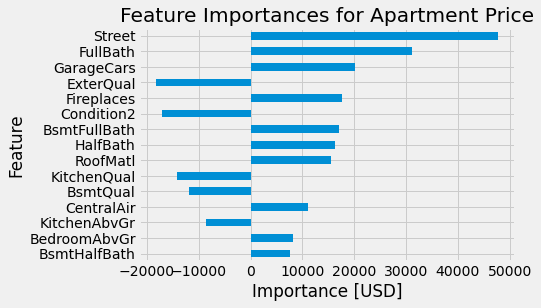

In [25]:
coefficients = model.coef_
features = train.columns
feat_imp = pd.Series(coefficients,index=features).sort_values(key=abs).tail(15)
# Build bar chart for the 15 most influential coefficients of the model
feat_imp.plot(kind="barh")
# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
# Add title
plt.title("Feature Importances for Apartment Price");

In [26]:
#save the model for future use,using pickle
import pickle 

pickle.dump(model, open('model_house.pkl', 'wb'))

In [28]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(train_data,y_train)
eli5.show_weights(perm, feature_names = train_data.columns.tolist())

Weight,Feature
0.0927 ± 0.0089,FullBath
0.0686 ± 0.0087,GarageCars
0.0506 ± 0.0072,ExterQual
0.0441 ± 0.0082,KitchenQual
0.0422 ± 0.0073,Fireplaces
0.0361 ± 0.0111,BsmtQual
0.0238 ± 0.0040,BsmtFullBath
0.0205 ± 0.0010,HalfBath
0.0139 ± 0.0035,BedroomAbvGr
0.0132 ± 0.0026,BsmtExposure
